In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.15.0
GPU available: []


In [2]:
# Define paths
appendicitis_path = "images/appendicitis_images_undersampling/"
no_appendicitis_path = "images/no_appendicitis_images_undersampling/"

# Function to load and explore dataset
def explore_dataset():
    # Count images in each category
    appendicitis_count = len([f for f in os.listdir(appendicitis_path) 
                             if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))])
    no_appendicitis_count = len([f for f in os.listdir(no_appendicitis_path) 
                                if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))])
    
    print(f"Appendicitis images: {appendicitis_count}")
    print(f"No appendicitis images: {no_appendicitis_count}")
    print(f"Total images: {appendicitis_count + no_appendicitis_count}")
    
    return appendicitis_count, no_appendicitis_count

appendicitis_count, no_appendicitis_count = explore_dataset()

Appendicitis images: 377
No appendicitis images: 382
Total images: 759


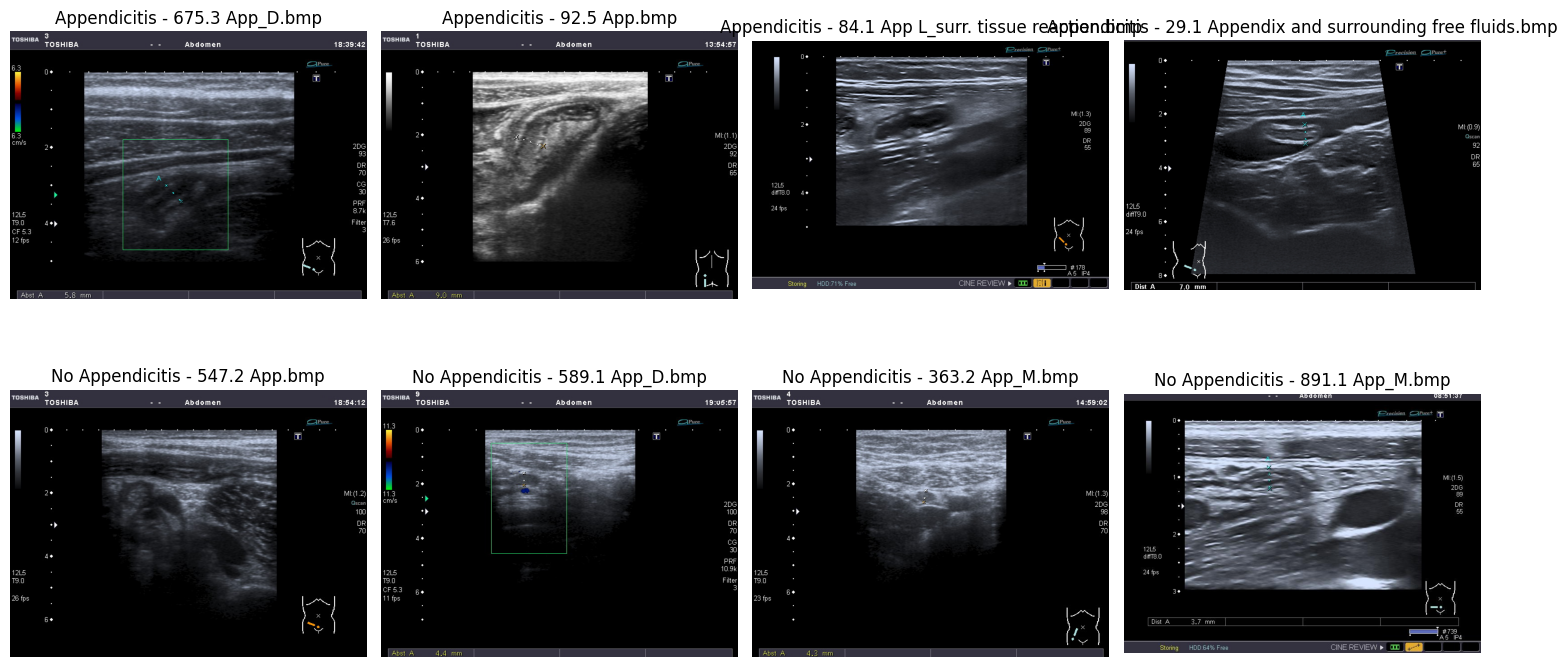

In [3]:
def plot_sample_images(num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    # Plot appendicitis samples
    appendicitis_files = [f for f in os.listdir(appendicitis_path) 
                         if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    for i in range(min(num_samples, len(appendicitis_files))):
        img_path = os.path.join(appendicitis_path, appendicitis_files[i])
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Appendicitis - {appendicitis_files[i]}')
        axes[0, i].axis('off')
    
    # Plot no appendicitis samples
    no_appendicitis_files = [f for f in os.listdir(no_appendicitis_path) 
                            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    for i in range(min(num_samples, len(no_appendicitis_files))):
        img_path = os.path.join(no_appendicitis_path, no_appendicitis_files[i])
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'No Appendicitis - {no_appendicitis_files[i]}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images()

In [4]:
def load_and_preprocess_data(img_size=(224, 224)):
    """
    Load and preprocess images from both categories
    """
    images = []
    labels = []
    
    # Load appendicitis images (label = 1)
    print("Loading appendicitis images...")
    appendicitis_files = [f for f in os.listdir(appendicitis_path) 
                         if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    
    for filename in appendicitis_files:
        try:
            img_path = os.path.join(appendicitis_path, filename)
            img = Image.open(img_path)
            
            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Resize image
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]
            
            images.append(img_array)
            labels.append(1)  # Appendicitis
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    # Load no appendicitis images (label = 0)
    print("Loading no appendicitis images...")
    no_appendicitis_files = [f for f in os.listdir(no_appendicitis_path) 
                            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    
    for filename in no_appendicitis_files:
        try:
            img_path = os.path.join(no_appendicitis_path, filename)
            img = Image.open(img_path)
            
            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Resize image
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]
            
            images.append(img_array)
            labels.append(0)  # No appendicitis
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    return np.array(images), np.array(labels)

# Load the data
X, y = load_and_preprocess_data()
print(f"Loaded {len(X)} images with shape: {X.shape}")
print(f"Labels distribution: {np.bincount(y)}")

Loading appendicitis images...
Loading no appendicitis images...
Loaded 759 images with shape: (759, 224, 224, 3)
Labels distribution: [382 377]


In [5]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Check class distribution
print("\nClass distribution:")
print(f"Train - Appendicitis: {np.sum(y_train)}, No appendicitis: {len(y_train) - np.sum(y_train)}")
print(f"Val - Appendicitis: {np.sum(y_val)}, No appendicitis: {len(y_val) - np.sum(y_val)}")
print(f"Test - Appendicitis: {np.sum(y_test)}, No appendicitis: {len(y_test) - np.sum(y_test)}")

Training set: 531 images
Validation set: 114 images
Test set: 114 images

Class distribution:
Train - Appendicitis: 264, No appendicitis: 267
Val - Appendicitis: 57, No appendicitis: 57
Test - Appendicitis: 56, No appendicitis: 58


In [7]:
# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator()

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)
print(f"Weight for no appendicitis (class 0): {class_weight_dict[0]:.2f}")
print(f"Weight for appendicitis (class 1): {class_weight_dict[1]:.2f}")

Class weights: {0: 0.9943820224719101, 1: 1.0056818181818181}
Weight for no appendicitis (class 0): 0.99
Weight for appendicitis (class 1): 1.01


In [8]:
def create_vgg_model(input_shape=(224, 224, 3), num_classes=1):
    """
    Create a VGG16-based model for binary classification
    """
    # Load pre-trained VGG16 without top layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the base model initially
    base_model.trainable = False
    
    # Add custom classification layers
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

# Create the model
model = create_vgg_model()

# Display model architecture
model.summary()

# Count trainable parameters
trainable_params = model.count_params()
print(f"\nTotal trainable parameters: {trainable_params:,}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [9]:
import tensorflow.keras.backend as K

def f1_score(y_true, y_pred):
    """Custom F1 score metric"""
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val*recall_val)/(precision_val+recall_val+K.epsilon()))

# Then recompile with this custom metric:
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        f1_score
    ]
)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Create callbacks (updated to monitor val_accuracy instead of val_f1_score)
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_appendicitis_model_undersampling.keras',
        monitor='val_accuracy',  # Changed from val_f1_score
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured!")

Callbacks configured!


In [11]:
# Convert labels to float32 to avoid dtype issues
y_train_float = y_train.astype(np.float32)
y_val_float = y_val.astype(np.float32)

# First phase: Train only the top layers
print("Starting Phase 1: Training custom layers only...")
print(f"Base model trainable: {model.layers[0].trainable}")

history_phase1 = model.fit(
    train_datagen.flow(X_train, y_train_float, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val_float),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("Phase 1 training completed!")

Starting Phase 1: Training custom layers only...
Base model trainable: False
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.5593 - precision: 0.5540 - recall: 0.5833 - f1_score: 0.5536
Epoch 1: val_accuracy improved from -inf to 0.59649, saving model to best_appendicitis_model_undersampling.keras
17/17 [==============================] - 73s 4s/step - loss: 0.7445 - accuracy: 0.5593 - precision: 0.5540 - recall: 0.5833 - f1_score: 0.5536 - val_loss: 0.6788 - val_accuracy: 0.5965 - val_precision: 0.5604 - val_recall: 0.8947 - val_f1_score: 0.6859 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.6384 - precision: 0.6395 - recall: 0.6250 - f1_score: 0.6255
Epoch 2: val_accuracy did not improve from 0.59649
17/17 [==============================] - 78s 5s/step - loss: 0.6562 - accuracy: 0.6384 - precision: 0.6395 - recall: 0.6250 - f1_score: 0.6255 - val_loss: 0.6781 - val_accuracy: 0.5614 - val_pr

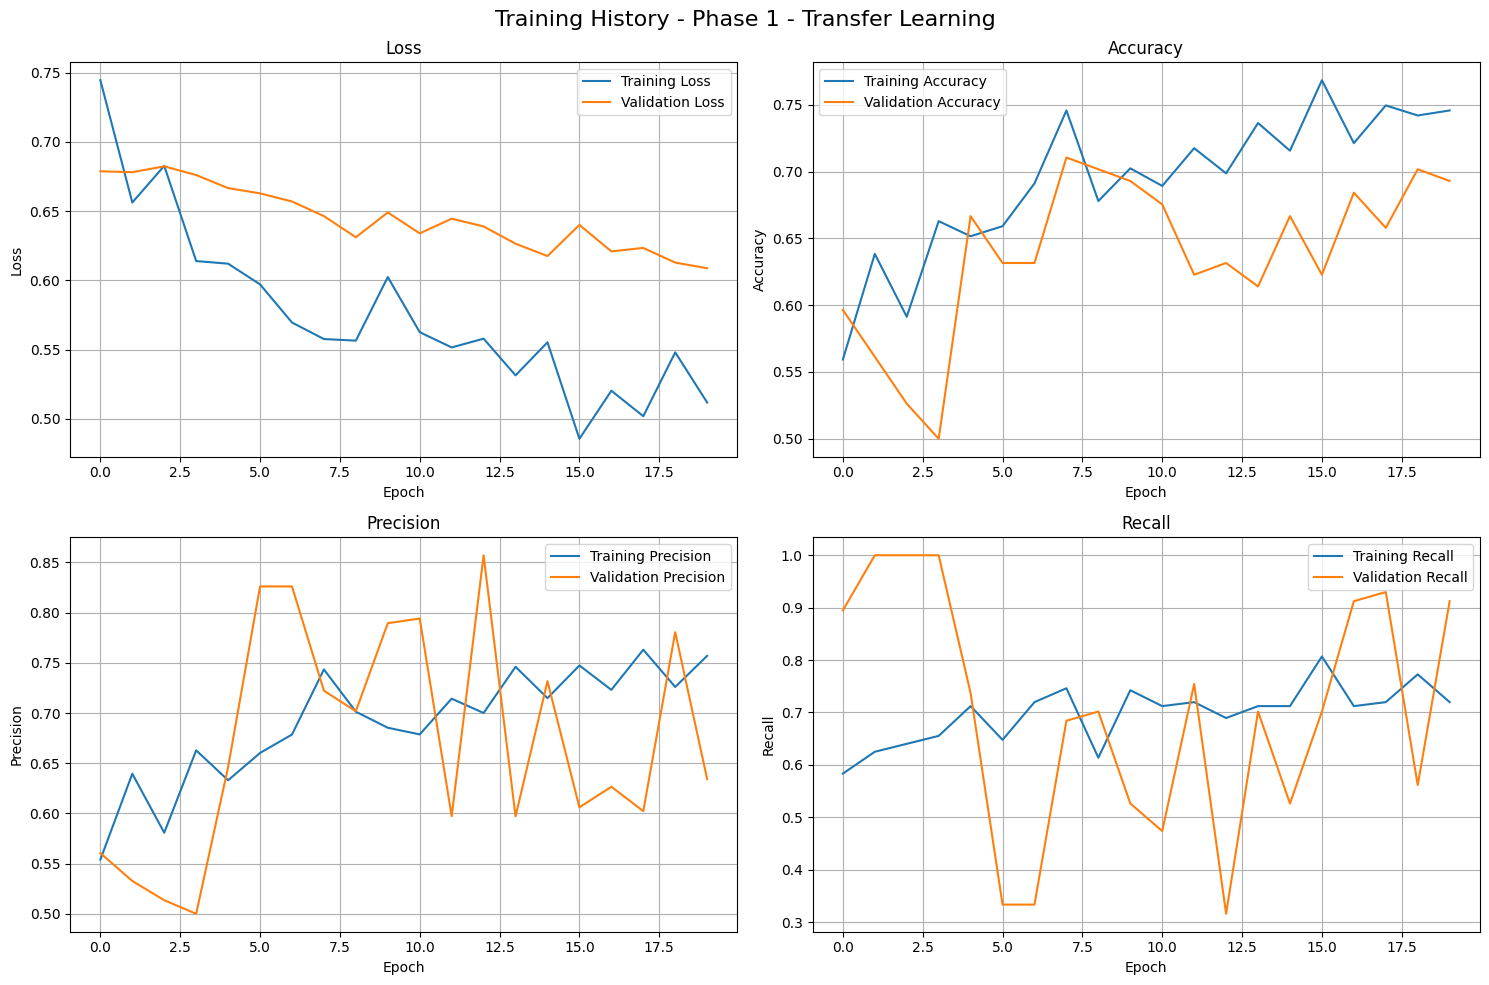

In [13]:
def plot_training_history(history, phase_name=""):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Training History - {phase_name}', fontsize=16)
    
    # Plot loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot Phase 1 results
plot_training_history(history_phase1, "Phase 1 - Transfer Learning")

Phase 1 - Validation Set Evaluation:
4/4 [==============================] - 13s 3s/step

Classification Report:
                 precision    recall  f1-score   support

No Appendicitis       0.84      0.47      0.61        57
   Appendicitis       0.63      0.91      0.75        57

       accuracy                           0.69       114
      macro avg       0.74      0.69      0.68       114
   weighted avg       0.74      0.69      0.68       114



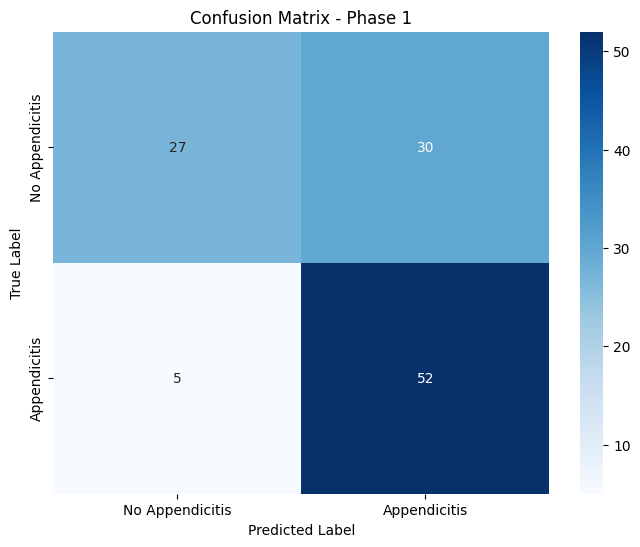


Sensitivity (Recall): 0.912
Specificity: 0.474


In [14]:
# Evaluate on validation set
print("Phase 1 - Validation Set Evaluation:")
val_predictions = model.predict(X_val)
val_predictions_binary = (val_predictions > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, val_predictions_binary, 
                          target_names=['No Appendicitis', 'Appendicitis']))

# Confusion Matrix
cm = confusion_matrix(y_val, val_predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Appendicitis', 'Appendicitis'],
            yticklabels=['No Appendicitis', 'Appendicitis'])
plt.title('Confusion Matrix - Phase 1')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print some metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"\nSensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

In [15]:
# Unfreeze the top layers of VGG16 for fine-tuning
base_model = model.layers[0]

# Freeze the first layers, unfreeze the last few blocks
for layer in base_model.layers[:-4]:  # Freeze all but last 4 layers
    layer.trainable = False

for layer in base_model.layers[-4:]:  # Unfreeze last 4 layers
    layer.trainable = True

print("Fine-tuning setup:")
print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

print("Model recompiled for fine-tuning!")

Fine-tuning setup:
Total layers in base model: 19
Trainable layers: 4
Model recompiled for fine-tuning!


In [16]:
# Reset callbacks for phase 2
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,  # Reduced patience for fine-tuning
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        'best_appendicitis_model_phase2_undersampling.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Starting Phase 2: Fine-tuning...")

history_phase2 = model.fit(
    train_datagen.flow(X_train, y_train_float, batch_size=16),  # Smaller batch size
    epochs=15,  # Fewer epochs for fine-tuning
    validation_data=(X_val, y_val_float),
    class_weight=class_weight_dict,
    callbacks=callbacks_phase2,
    verbose=1
)

print("Phase 2 training completed!")

Starting Phase 2: Fine-tuning...
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.7476 - precision: 0.7539 - recall: 0.7311
Epoch 1: val_accuracy improved from -inf to 0.68421, saving model to best_appendicitis_model_phase2_undersampling.keras
34/34 [==============================] - 75s 2s/step - loss: 0.4846 - accuracy: 0.7476 - precision: 0.7539 - recall: 0.7311 - val_loss: 0.5937 - val_accuracy: 0.6842 - val_precision: 0.6329 - val_recall: 0.8772 - lr: 1.0000e-04
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.7495 - precision: 0.7549 - recall: 0.7348
Epoch 2: val_accuracy improved from 0.68421 to 0.70175, saving model to best_appendicitis_model_phase2_undersampling.keras
34/34 [==============================] - 82s 2s/step - loss: 0.4767 - accuracy: 0.7495 - precision: 0.7549 - recall: 0.7348 - val_loss: 0.5816 - val_accuracy: 0.7018 - val_precision: 0.6494 - val_recall: 0.8772 - lr: 1.0000e-04
Epoch 

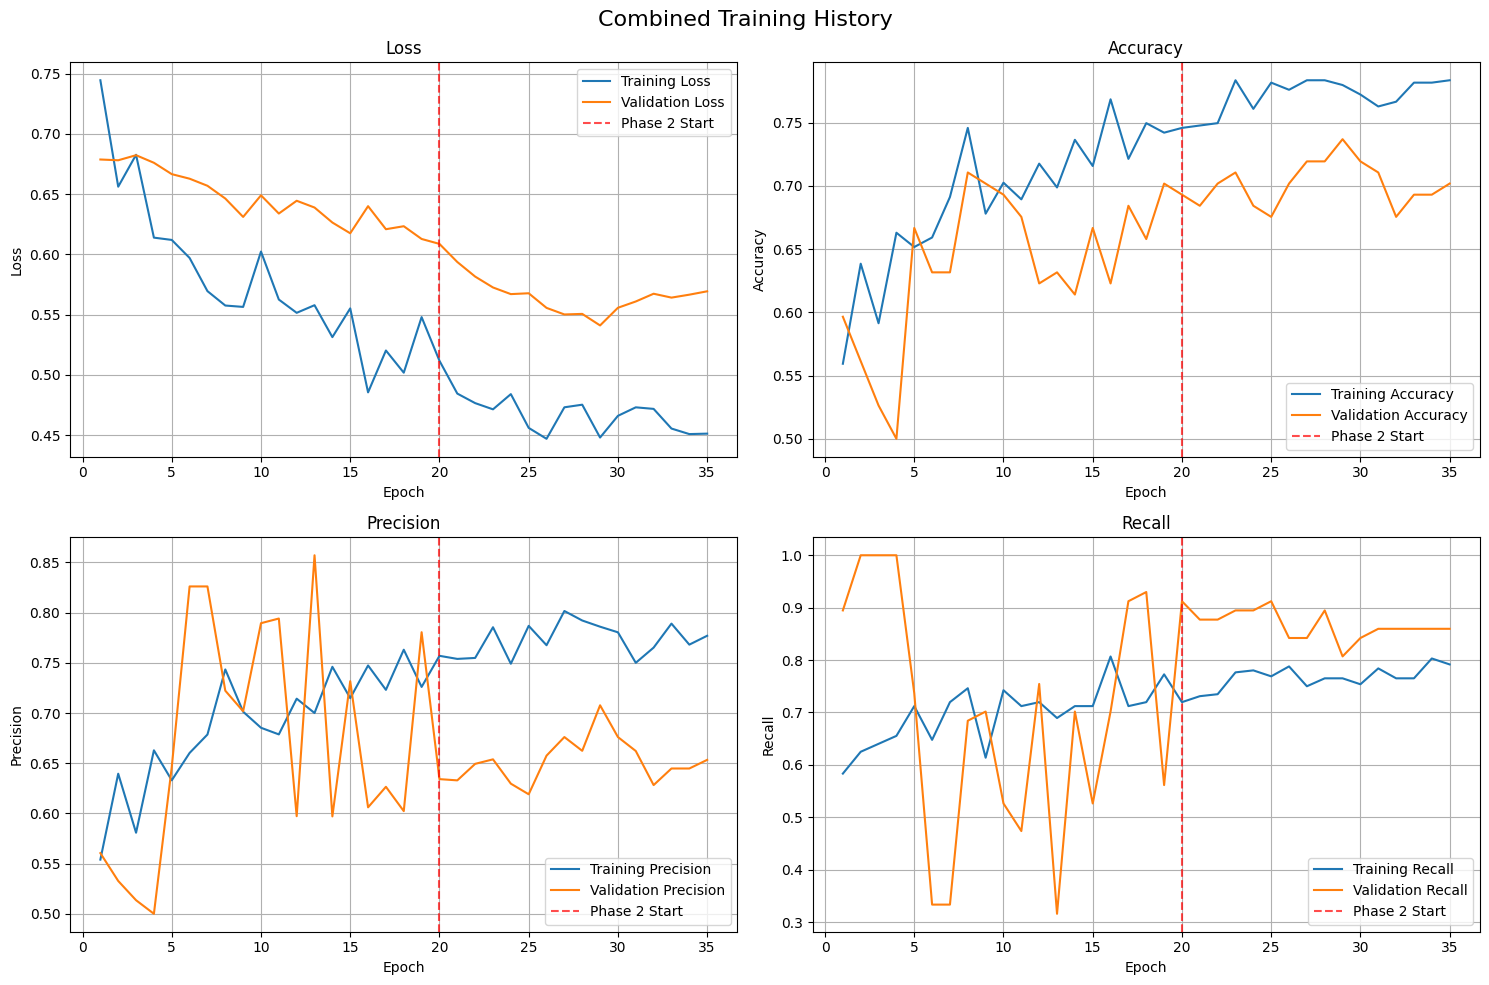

In [17]:
def plot_combined_history(hist1, hist2, phase1_name="Phase 1", phase2_name="Phase 2"):
    """
    Plot combined training history from both phases
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Combined Training History', fontsize=16)
    
    # Combine histories
    phase1_epochs = len(hist1.history['loss'])
    total_epochs = range(1, phase1_epochs + len(hist2.history['loss']) + 1)
    combined_loss = hist1.history['loss'] + hist2.history['loss']
    combined_val_loss = hist1.history['val_loss'] + hist2.history['val_loss']
    combined_acc = hist1.history['accuracy'] + hist2.history['accuracy']
    combined_val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']
    
    # Plot loss
    axes[0, 0].plot(total_epochs, combined_loss, label='Training Loss')
    axes[0, 0].plot(total_epochs, combined_val_loss, label='Validation Loss')
    axes[0, 0].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot accuracy
    axes[0, 1].plot(total_epochs, combined_acc, label='Training Accuracy')
    axes[0, 1].plot(total_epochs, combined_val_acc, label='Validation Accuracy')
    axes[0, 1].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot precision
    combined_precision = hist1.history['precision'] + hist2.history['precision']
    combined_val_precision = hist1.history['val_precision'] + hist2.history['val_precision']
    axes[1, 0].plot(total_epochs, combined_precision, label='Training Precision')
    axes[1, 0].plot(total_epochs, combined_val_precision, label='Validation Precision')
    axes[1, 0].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot recall
    combined_recall = hist1.history['recall'] + hist2.history['recall']
    combined_val_recall = hist1.history['val_recall'] + hist2.history['val_recall']
    axes[1, 1].plot(total_epochs, combined_recall, label='Training Recall')
    axes[1, 1].plot(total_epochs, combined_val_recall, label='Validation Recall')
    axes[1, 1].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot combined results
plot_combined_history(history_phase1, history_phase2)

Final Evaluation on Test Set:
Test Loss: 0.6750
Test Accuracy: 0.6754
Test Precision: 0.6338
Test Recall: 0.8036
4/4 [==============================] - 14s 3s/step

Final Test Set Classification Report:
                 precision    recall  f1-score   support

No Appendicitis       0.74      0.55      0.63        58
   Appendicitis       0.63      0.80      0.71        56

       accuracy                           0.68       114
      macro avg       0.69      0.68      0.67       114
   weighted avg       0.69      0.68      0.67       114



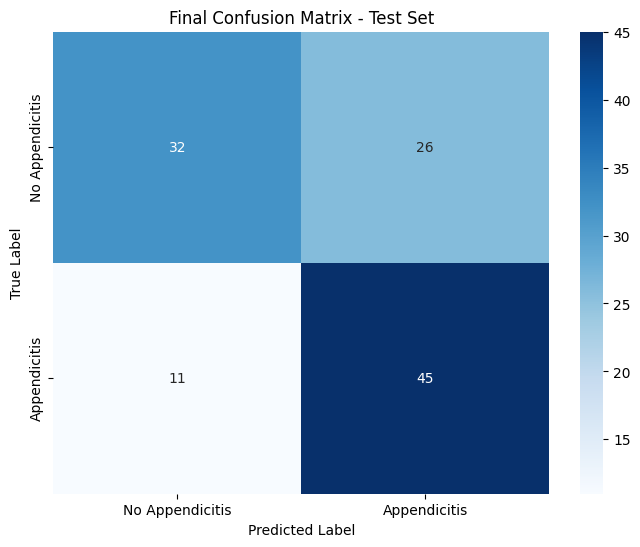


Final Test Metrics:
Sensitivity (Recall): 0.804
Specificity: 0.552
F1-Score: 0.709
Balanced Accuracy: 0.678


In [18]:
# Convert test labels to float32
y_test_float = y_test.astype(np.float32)

# Final evaluation on test set
print("Final Evaluation on Test Set:")
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test_float, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Get predictions
test_predictions = model.predict(X_test)
test_predictions_binary = (test_predictions > 0.5).astype(int).flatten()

# Detailed classification report
print("\nFinal Test Set Classification Report:")
print(classification_report(y_test, test_predictions_binary, 
                          target_names=['No Appendicitis', 'Appendicitis']))

# Final confusion matrix
cm_test = confusion_matrix(y_test, test_predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Appendicitis', 'Appendicitis'],
            yticklabels=['No Appendicitis', 'Appendicitis'])
plt.title('Final Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate final metrics
tn, fp, fn, tp = cm_test.ravel()
final_sensitivity = tp / (tp + fn)
final_specificity = tn / (tn + fp)
final_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"\nFinal Test Metrics:")
print(f"Sensitivity (Recall): {final_sensitivity:.3f}")
print(f"Specificity: {final_specificity:.3f}")
print(f"F1-Score: {final_f1:.3f}")
print(f"Balanced Accuracy: {(final_sensitivity + final_specificity) / 2:.3f}")

In [19]:
# Save the complete model
model.save('final_appendicitis_vgg_model_undersampling.keras')
print("Model saved as 'final_appendicitis_vgg_model_undersampling.keras'")

# Save model architecture as JSON
model_json = model.to_json()
with open("appendicitis_model_architecture_undersampling.json", "w") as json_file:
    json_file.write(model_json)

# Save only the weights
model.save_weights("appendicitis_model_weights_undersampling.keras")
print("Model architecture and weights saved separately")

Model saved as 'final_appendicitis_vgg_model_undersampling.keras'
Model architecture and weights saved separately


In [20]:
def predict_appendicitis(image_path, model_path, threshold=0.5):
    """
    Predict appendicitis for a new ultrasound image
    
    Args:
        image_path: Path to the image file
        model_path: Path to the saved model file (.h5 or .keras)
        threshold: Decision threshold (default 0.5)
    
    Returns:
        Dictionary with prediction results
    """
    try:
        # Load the model from file
        loaded_model = tf.keras.models.load_model(model_path)
        
        # Load and preprocess image
        img = Image.open(image_path)
        
        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to model input size
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Make prediction
        prediction_prob = loaded_model.predict(img_array, verbose=0)[0][0]
        prediction_binary = int(prediction_prob > threshold)
        
        # Prepare result
        result = {
            'image_path': image_path,
            'probability': float(prediction_prob),
            'prediction': 'Appendicitis' if prediction_binary == 1 else 'No Appendicitis',
            'confidence': float(max(prediction_prob, 1 - prediction_prob)),
            'threshold_used': threshold
        }
        
        return result
        
    except Exception as e:
        return {'error': str(e), 'image_path': image_path}

In [30]:
# Create a simple deployment script
deployment_code = '''
import numpy as np
from PIL import Image
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('final_appendicitis_vgg_model_undersampling.keras')

def predict_single_image(image_path, threshold=0.5):
    """
    Predict appendicitis for a single ultrasound image
    """
    # Load and preprocess image
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    prediction_prob = model.predict(img_array)[0][0]
    prediction = "Appendicitis" if prediction_prob > threshold else "No Appendicitis"
    confidence = max(prediction_prob, 1 - prediction_prob)
    
    return {
        'prediction': prediction,
        'probability': float(prediction_prob),
        'confidence': float(confidence)
    }

# Example usage:
# result = predict_single_image('path/to/ultrasound_image.bmp')
# print(result)
'''

with open('deploy_model.py', 'w') as f:
    f.write(deployment_code)
    
print("Deployment script created as 'deploy_model.py'")

Deployment script created as 'deploy_model.py'


In [26]:
# Now test with your exact call
result = predict_appendicitis("images/no_appendicitis_images/216.5 App_M.bmp", 
                             "final_appendicitis_vgg_model_undersampling.keras")
print("Prediction result:", result)

Prediction result: {'image_path': 'images/no_appendicitis_images/216.5 App_M.bmp', 'probability': 0.5082553625106812, 'prediction': 'Appendicitis', 'confidence': 0.5082553625106812, 'threshold_used': 0.5}
